/Users/xingshengzhao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


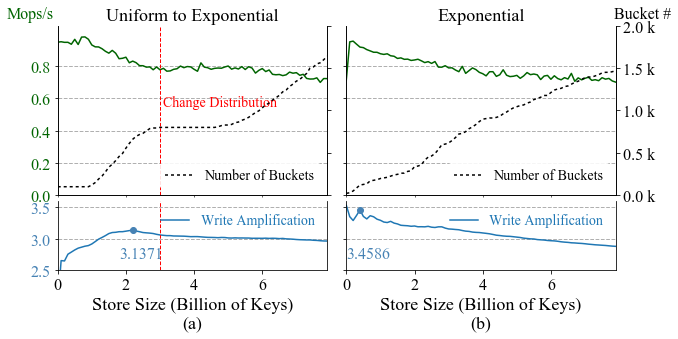

In [17]:
import re
import os
import csv
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from natsort import natsorted, ns
from scipy.fftpack import fft
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.weight'] = 100
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

%matplotlib inline

def extract_current(speeds):
    result = re.findall(r"[-+]?\d*\.\d+|\d+", speeds)
    return float(result[0])

fig = plt.figure(figsize=(10, 4.5)) 
gs = gridspec.GridSpec(10, 10) 
gs.update(wspace=0.5, hspace=0.3) # set the spacing between axes. 

# ax1 = plt.subplot(gs[:5, 0:3])
# ax2 = plt.subplot(gs[5:, 0:3])

ax3 = plt.subplot(gs[:7, :5])
ax4 = plt.subplot(gs[7:, :5])

ax5 = plt.subplot(gs[:7, 5:])
ax6 = plt.subplot(gs[7:, 5:])



# df = pd.read_csv("uniform_10M.txt")
# df = df.drop(df.columns[[1]],axis=1)
# df.columns = ["data"]
# ax1.hist(df["data"], bins=10,  edgecolor='black')
# ax1.set_ylabel("Uniform", fontsize=20)
# ax1.yaxis.set_label_coords(-0.7,0.52)
# ax1.set_xticks([])
# ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(df["data"]), decimals=1))

# df = pd.read_csv("exponential_10M.txt")
# df = df.drop(df.columns[[1]],axis=1)
# df.columns = ["data"]
# ax2.hist(df["data"], bins=10, edgecolor='black')
# ax2.set_ylabel("Exponential", fontsize=20)
# ax2.yaxis.set_label_coords(-0.7,0.52)

# ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(df["data"]), decimals=0))
# ax2.set_xticks([])

df2 = pd.DataFrame(columns = []) 
def ReadFile(name, file):
    wip = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    wip_bucket = pd.DataFrame(columns = ['Bucket']) 
    wip_wa = pd.DataFrame(columns = ['Write Amplification']) 
    with open(file) as origin_file:
        for line in origin_file:
            if line.startswith("20"):
                data = line.strip().split()
                data = [data[i] for i in (0,3,4,7)]
                wip.loc[len(wip)] = data
            if line.startswith("Bucket"):
                data = line.strip().split();
                wip_bucket.loc[len(wip_bucket)] = float(data[1])  
            if line.startswith("WriteAmplification"):
                data = line.strip().split();
                wip_wa.loc[len(wip_wa)] = float(data[1])  
    df2[name] = wip['speed'].apply(extract_current)
    df2[name] = df2[name] / 1000.0 / 1000.0
    df2[name + '_bucket'] = wip_bucket["Bucket"] / 1000
    df2[name + '_wa'] = wip_wa["Write Amplification"]

ReadFile("wip_3","kv8B_nvm_hugepage_changeDistribution3B5B.log")
ReadFile("wip_exp","kv8B_nvm_hugepage_splitwhen3B.log")
ReadFile("wip_stress","kv8B_nvm_hugepage_stress.log")

def MyPlot(title, name, ax_up, ax_down, wa_pos, is_left_y=False, is_right_y=False, x_title="(a)"):
    def billions(x, pos):
        'The two args are the value and tick position'
        return '%1.0f' % (x/10)
    def ytickformat(x, pos):
        return '%1.1f' % (x)
    def ytickformat2(x, pos):
        return '%1.1f' % (x/1000.0)

    
    formatter = FuncFormatter(billions)
    formattery = FuncFormatter(ytickformat)
    df2[name].plot(ax=ax_up, fontsize=20, color='darkgreen')
    ax_up.set_title(title, fontsize=18)
    ax_up.yaxis.grid(linewidth=1, linestyle='--')
    ax_up.set_axisbelow(True)
    ax_up.yaxis.set_major_formatter(formattery)
    ax_up.tick_params(axis="y", labelsize=16)
    major_ticks = np.arange(0, 1, 0.2)
    ax_up.set_yticks(major_ticks)
    ax_up.set_ylim([0, 1.05])
    ax_up.set_xticks([])
    ax_up.spines["top"].set_visible(False) 
    ax_up.yaxis.set_label_coords(0.06, 1)
    ax_up.tick_params(axis='y', labelcolor='darkgreen')
    axt = ax_up.twinx();
    axt.spines["top"].set_visible(False) 
    df2[name + '_bucket'].plot(ax=axt, dashes=[2, 2], color='k', markersize=8)
    axt.set_ylim([0, 2])
    axt.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1f k'))
    
    axt.legend(["Number of Buckets"], loc="lower right", fontsize=14, edgecolor='w')
    df2[name + '_wa'].plot(ax=ax_down)
    ax_down.plot([wa_pos], [df2[name + '_wa'][wa_pos]], color='steelblue', marker='o')
    ax_down.text(wa_pos - 4, 2.7, df2[name + '_wa'][wa_pos], color='steelblue', fontsize=16)
    ax_down.yaxis.grid(linewidth=1, linestyle='--')
    ax_down.set_axisbelow(True)
    ax_down.spines["top"].set_visible(False) 
    ax_down.tick_params(axis='y', labelcolor='steelblue')
    ax_down.xaxis.set_major_formatter(formatter)
    ax_down.set_ylim([2.5, 3.6])
    
    if(not is_left_y):
        ax_up.set_yticklabels([])
        ax_down.set_yticklabels([])
    else:
        ax_up.set_ylabel( 'Mops/s', fontsize=16, color='darkgreen', va='bottom', rotation=0)
        ax_up.yaxis.set_label_coords(-0.1,1.02)
    if(not is_right_y):
        axt.set_yticklabels([])
    else:
        axt.set_ylabel( 'Bucket #', fontsize=16, color='k', va='bottom', rotation=0)
        axt.yaxis.set_label_coords(1.1,1.02)
    # set legend font color same as the line color
    leg = ax_down.legend(["Write Amplification"], loc="upper right", fontsize=14, edgecolor='w',framealpha=0)
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())
    ax_down.set_xlabel(x_title, fontsize=18)
    
# MyPlot("Uniform",'wip', ax3, ax4, 21, True, False, "(a)")
MyPlot("Uniform to Exponential",'wip_exp', ax3, ax4, 22, True, False, "Store Size (Billion of Keys)\n(a)")
MyPlot("Exponential",'wip_stress', ax5, ax6, 4, False, True, "Store Size (Billion of Keys)\n(b)")

# add vertical grid line
style = dict(size=14, color='red')
ax3.axvline(30, linestyle='--', color='red', linewidth=1) # vertical lines
ax3.text(31, 0.55, "Change Distribution", **style)
ax4.axvline(30, linestyle='--', color='red', linewidth=1) # vertical lines


fig.tight_layout()
plt.savefig("8BInsertSplit.pdf", bbox_inches='tight')



/Users/xingshengzhao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


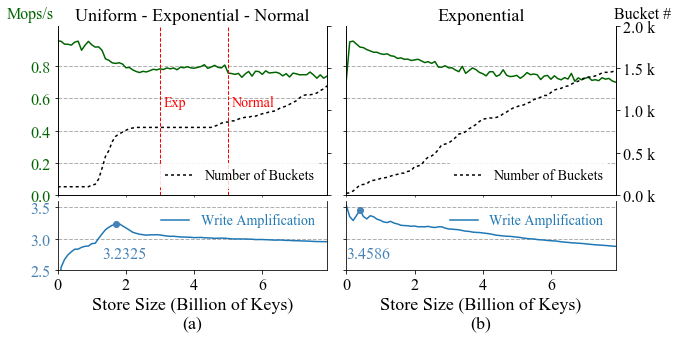

In [16]:

fig = plt.figure(figsize=(10, 4.5)) 
gs = gridspec.GridSpec(10, 10) 
gs.update(wspace=0.5, hspace=0.3) # set the spacing between axes. 

ax3 = plt.subplot(gs[:7, :5])
ax4 = plt.subplot(gs[7:, :5])

ax5 = plt.subplot(gs[:7, 5:])
ax6 = plt.subplot(gs[7:, 5:])


# MyPlot("Uniform",'wip', ax3, ax4, 21, True, False, "(a)")
MyPlot("Uniform - Exponential - Normal",'wip_3', ax3, ax4, 17, True, False, "Store Size (Billion of Keys)\n(a)")
MyPlot("Exponential",'wip_stress', ax5, ax6, 4, False, True, "Store Size (Billion of Keys)\n(b)")

# add vertical grid line
style = dict(size=14, color='red')
ax3.axvline(30, linestyle='--', color='red', linewidth=1) # vertical lines
ax3.text(31, 0.55, "Exp", **style)
# ax4.axvline(30, linestyle='--', color='red', linewidth=1) # vertical lines

ax3.axvline(50, linestyle='--', color='red', linewidth=1) # vertical lines
ax3.text(51, 0.55, "Normal", **style)
# ax4.axvline(50, linestyle='--', color='red', linewidth=1) # vertical lines

fig.tight_layout()
plt.savefig("8BInsertSplit3.pdf", bbox_inches='tight')